In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import astropy.wcs as wcs

from sklearn.mixture import GaussianMixture

In [2]:
#### DESCRIPTION/NOTES ####

## Works for a 3D spectral datacube, clusters based on spectra (see Kabanovic+2020 for a description)

###############

In [3]:
## input ##

## input for the data file
name_file = '../RCW79/RCW79_CII_PCA_20_8_0p5_clean.fits'
unit_integrated_intensity = '$\int$T$_{mb}$dv (K km s$^{-1}$)'

## input for the Gaussian Mixture Models
n_comps_min = 2
n_comps_max = 10
seed_val = 108
threshold = 0.001#1e-4
gmm_iter = 1000

## information for the observational information
noise_rms_obs = 0.6 ## K
min_velocity = -70. ## km/s
max_velocity = -25. ## km/s

In [4]:
## store data and header
hdu = pyfits.open(name_file)
hdu.info()
data = hdu[0].data
header = hdu[0].header

## store the spectral information
dv = 0.001*header['CDELT3']
crval = 0.001*header['CRVAL3']
crpix = header['CRPIX3']
print(dv)

## store the WCS information
header_c = header.copy()
header_c['NAXIS'] = 2
del header_c['NAXIS3']
del header_c['CTYPE3']
del header_c['CRVAL3']
del header_c['CDELT3']
del header_c['CRPIX3']
del header_c['CROTA3']

w = wcs.WCS(header_c)

Filename: ../RCW79/RCW79_CII_PCA_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (188, 188, 160)   float32   
0.5


## Definitions

In [5]:
## inspect the data using the integrated intensity map

def inspect_intensity_map(dat,wVal,unit_integrated_intensity):
    int_map = dv*np.nansum(dat,axis=0)
    
    fig, ax = plt.subplots()
    ax1 = fig.add_subplot(111, projection=wVal)
    im = ax1.imshow(int_map, origin='lower', vmin=0., cmap = 'jet')
    
    plt.xlim([0, len(int_map[0])])
    plt.ylim([0, len(int_map)])
    
    plt.xlabel('RA [J2000]')
    plt.ylabel('DEC [J2000]',labelpad=-1.)
    
    cbar = fig.colorbar(im)
    cbar.set_label(unit_integrated_intensity, labelpad=15.,rotation=270.)
    
    ax.axis('off')
    plt.show()

In [6]:
def vel_to_pixel(vel, crval, dv, crpix):
    pixel = int((vel - crval)/dv + crpix + 0.5)
    return pixel

In [7]:
## prepare the data for input into the GMM model

def prepare_data(data, min_vel, max_vel, crval, dv, crpix):
    ## clip the spectra to the velocity range associated with emission
    z_min = vel_to_pixel(min_vel, crval, dv, crpix)
    z_max = vel_to_pixel(max_vel, crval, dv, crpix)
    data_resample = data[z_min:z_max,:,:]
    ## verification
    print("The minimal pixel along the z-axis is:" + str(z_min))
    print("The maximal pixel along the z-axis is:" + str(z_max))
    
    
    ## resample data, so that the GMM can handle it
    ## i.e. resample the data to a single array of the spectra
    len_resample = len(data_resample[0])*len(data_resample[0][0])
    data_resample = data_resample.reshape(len(data_resample),len_resample)
    print(data_resample.shape)
    
    
    ## create an array to keep track of the indices
    index_arr = [int(j) for j in range(0,len_resample)]
    index_arr = np.array(index_arr)
    print("Dimensions of index_arr: " + str(index_arr.shape))
    print(index_arr)
    
    
    ## normalize the data: maximum value = 1
    max_vals = np.nanmax(data_resample,axis=0)
    data_resample = data_resample / max_vals[np.newaxis, :]
    ## verification
    print("Dimensions of max_vals: " + str(max_vals.shape))
    print(max_vals)
    print("The maximum value is: " + str(np.nanmax(data_resample)))
    print("The minimum value is: " + str(np.nanmin(data_resample)))
    
    
    ## remove nan-data from data and index array
    index_arr = index_arr[~np.isnan(max_vals)]
    mask = np.full((len_resample),True)
    mask[np.isnan(max_vals)] = False
    data_resample = data_resample[:,mask]
    ## verification
    
    ## transpose the arrays to provide as input for the GMM
    index_arr = index_arr.transpose()
    data_resample = data_resample.transpose()
    
    return index_arr, data_resample
    print("Final dimensions of index_arr: " + str(index_arr.shape))
    print("Final dimensions of data_resample: " + str(data_resample.shape))
    print(data_resample)

In [8]:
### run the GMM for a set number of components

def run_GMM(sample_data, num_comps, seed, threshold, max_iter):
    model = GaussianMixture(n_components=num_comps, init_params='kmeans', covariance_type='full', random_state=seed, tol=threshold, max_iter=max_iter).fit(sample_data)
    return model

In [9]:
## Use matplotlib to plot the input from two arrays

def plot_two_lists(list_x,list_y,label_x,label_y):
    plt.plot(list_x,list_y,'-o')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.show()

In [ ]:
## Maps the different clusters on the observed map in different colors
def map_spatial_cluster_distribution(cluster_inds_arr,index_arr,len_x_orig_map,len_y_orig):
    cluster_map = np.zeros((len_x_orig_map,len_y_orig_map),dtype=float)
    cluster_map[cluster_map==0] = np.nan
    for cluster_ind, ind in zip(cluster_inds_arr,index_arr):
        pos_x = ind%len_x_orig_map
        pos_y = int(ind/len_x_orig_map)
        cluster_map[pos_y][pos_x] = cluster_ind
    return cluster_map

In [ ]:
## plot the clusters in different colors (only work up to 10 clusters at the moment)
def plot_spatial_cluster_distribution(dat,wVal):
    fig, ax = plt.subplots()
    ax1 = fig.add_subplot(111, projection=wVal)
    im = ax1.imshow(dat, origin='lower', vmin=0., cmap = 'tab10')
    
    plt.xlim([0, len(dat[0])])
    plt.ylim([0, len(dat)])
    
    plt.xlabel('RA [J2000]')
    plt.ylabel('DEC [J2000]',labelpad=-1.)
    
    ax.axis('off')
    plt.show()

## Execute the script

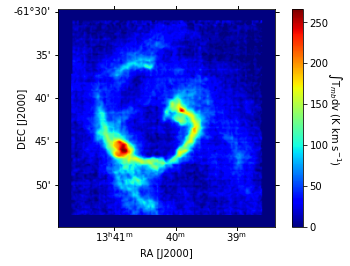

In [10]:
inspect_intensity_map(data, w, unit_integrated_intensity)

In [11]:
## prepare the data before the GMM loop
index_array, data_resample = prepare_data(data, min_velocity, max_velocity, crval, dv, crpix)

## loop over number of clusters for the GMM modeling
n_comps_list = []
bic_list = []
best_model = None
for i in range(n_comps_min,n_comps_max):
    print("Calculating GMM for " + str(i) + " number of components")
    n_comps_list.append(i)
    temp_model = run_GMM(data_resample, i, seed_val, threshold, gmm_iter)
    temp_bic = temp_model.bic(data_resample)
    ## store the best fitting model
    if(i==n_comps_min):
        best_model = temp_model
    elif(temp_bic<np.nanmin(bic_list)):
        best_model = temp_model
    bic_list.append(temp_bic)

The minimal pixel along the z-axis is:40
The maximal pixel along the z-axis is:130
(90, 35344)
Dimensions of index_arr: (35344,)
[    0     1     2 ... 35341 35342 35343]
Dimensions of max_vals: (35344,)
[nan nan nan ... nan nan nan]
The maximum value is: 1.0
The minimum value is: -2.0776825
Calculating GMM for 2 number of components


<ipython-input-7-7243bc533e47>:28: RuntimeWarning: All-NaN slice encountered
  max_vals = np.nanmax(data_resample,axis=0)


Calculating GMM for 3 number of components
Calculating GMM for 4 number of components
Calculating GMM for 5 number of components
Calculating GMM for 6 number of components
Calculating GMM for 7 number of components
Calculating GMM for 8 number of components
Calculating GMM for 9 number of components


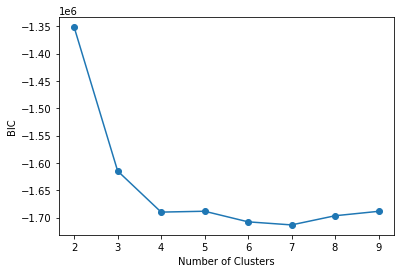

In [12]:
## plot BIC result as a function of the number of components
plot_two_lists(n_comps_list,bic_list,"Number of Clusters","BIC")

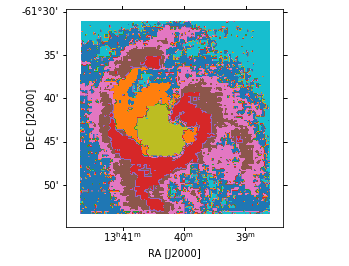

In [25]:
## Map the spatial distribution of the different clusters
cluster_inds = best_model.fit_predict(data_resample)
#print(clusters)
#print(clusters.shape)

len_x_orig_map = len(data[0][0])
len_y_orig_map = len(data[0])
cluster_map = map_spatial_cluster_distribution(cluster_inds,index_array,len_x_orig_map,len_y_orig_map)
plot_spatial_cluster_distribution(cluster_map,w)

SyntaxError: invalid syntax (<ipython-input-14-8190ca7e48cb>, line 2)